## Word2Vec from [nlintz's tutoral](https://github.com/nlintz/TensorFlow-Tutorials)

In [1]:
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline  

# Configuration
batch_size = 20
# Dimension of the embedding vector. Two too small to get
# any meaningful embeddings, but let's make it 2 for simple visualization
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.
    
# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]
# 'sentences' is 'list' 
print ("'sentences' is %s and length is %d." % (type(sentences), len(sentences)))

/home/koosy/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


'sentences' is <type 'list'> and length is 12.


In [2]:
# sentences to words and count
# words: list of all words (just concatenation) 
words = " ".join(sentences).split() 
# count: list of pairs, each pair consists of 'cats', 10
count = collections.Counter(words).most_common() 
print ("'words' is %s and length is %d." % (type(words), len(words)))
print ("'count' is %s and length is %d." % (type(count), len(count)))
print (("Word count of top five is %s") % (count[:5]))


'words' is <type 'list'> and length is 62.
'count' is <type 'list'> and length is 35.
Word count of top five is [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)]


In [3]:
# See what's in the 'words' and 'count'
print (words[0:5])
print (count[0:3])

['the', 'quick', 'brown', 'fox', 'jumped']
[('cats', 10), ('dogs', 6), ('and', 5)]


In [4]:
# Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word, e.g., rdic[0] is 'cats'
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id, e.g., dic['cats'] is 0
voc_size = len(dic) # Number of vocabulary 
print ("'rdic' is %s and length is %d." % (type(rdic), len(rdic)))
print ("'dic' is %s and length is %d." % (type(dic), len(dic)))

'rdic' is <type 'list'> and length is 35.
'dic' is <type 'dict'> and length is 35.


In [5]:
# See what's in the 'rdic' and 'rdic'
print (rdic[0])
print (dic['cats'])

cats
0


In [6]:
# Make indexed word data (ordered)
data = [dic[word] for word in words]
print ("'data' is %s and length is %d." % (type(data), len(data)))
print('Sample data: numbers: %s / words: %s'% (data[:10], [rdic[t] for t in data[:10]]))


'data' is <type 'list'> and length is 62.
Sample data: numbers: [8, 33, 24, 20, 17, 12, 8, 25, 30, 26] / words: ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I']


In [7]:
# See what's in the data
data

[8,
 33,
 24,
 20,
 17,
 12,
 8,
 25,
 30,
 26,
 4,
 0,
 2,
 1,
 13,
 10,
 4,
 0,
 2,
 1,
 0,
 2,
 1,
 3,
 7,
 6,
 34,
 0,
 31,
 32,
 1,
 0,
 23,
 5,
 21,
 27,
 0,
 3,
 7,
 19,
 11,
 28,
 15,
 16,
 5,
 0,
 3,
 14,
 0,
 3,
 29,
 18,
 22,
 9,
 0,
 2,
 1,
 1,
 2,
 0,
 4,
 6]

In [8]:
# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs: %s' % (cbow_pairs[:10]))

Context pairs: [[[8, 24], 33], [[33, 20], 24], [[24, 17], 20], [[20, 12], 17], [[17, 8], 12], [[12, 25], 8], [[8, 30], 25], [[25, 26], 30], [[30, 4], 26], [[26, 0], 4]]


In [9]:
# See type and length 
print ("'cbow_pairs' is %s and length is %d." % (type(cbow_pairs), len(cbow_pairs)))

'cbow_pairs' is <type 'list'> and length is 60.


In [10]:
# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
    
print ("'skip_gram_pairs' is %s and length is %d." % (type(skip_gram_pairs), len(skip_gram_pairs)))
print('skip-gram pairs', skip_gram_pairs[:5])

'skip_gram_pairs' is <type 'list'> and length is 120.
('skip-gram pairs', [[33, 8], [33, 24], [24, 33], [24, 20], [20, 24]])


In [11]:
def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
print ('Batches (x, y)', generate_batch(3))

('Batches (x, y)', ([13, 5, 15], [[10], [0], [16]]))


In [12]:
# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, voc_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.initialize_all_variables().run()

    for step in range(500):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 100 == 0:
            print("Loss at %d: %.5f" % (step, loss_val)) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()


Loss at 0: 16.61870
Loss at 100: 3.43583
Loss at 200: 3.14417
Loss at 300: 2.93138
Loss at 400: 2.98576


In [13]:
trained_embeddings.shape

(35, 2)

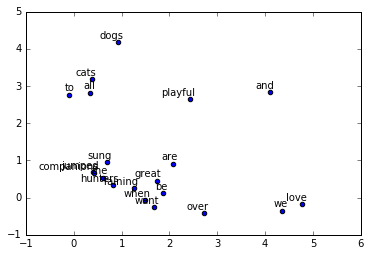

In [14]:
# Show word2vec if dim is 2
if trained_embeddings.shape[1] == 2:
    labels = rdic[:20] # Show top 20 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()
    